In [1]:
import os
from keras.models import Sequential, Model
from keras import layers, regularizers, optimizers
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
#import requests
import json
import numpy as np
import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)
from datetime import datetime
from sklearn import preprocessing
from sklearn.externals import joblib
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.
C:\Users\a.lunev\Anaconda3\envs\ML_GPU\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
my_data = np.genfromtxt('EURUSD-H1-2013-2019.csv', delimiter=',', skip_header=1)
#Translate date to day of week
for i, data in enumerate(my_data):
    my_data[i][0] = (datetime.strptime(str(data[0]), "%Y%m%d.0")).isoweekday()
# Add categorical day of week
bin_days = to_categorical(my_data[:,0])
my_data = np.delete(my_data, 0, 1)
my_data = np.delete(my_data, 0, 1)
my_data = np.concatenate((bin_days, my_data), axis=1)
# Calc High - Low
#my_data[:,9] = my_data[:,9] - my_data[:,10]
#my_data = np.delete(my_data, 10, 1)
# Mark data
Y = my_data[:,11] > my_data[:,8]
Y = Y.astype('int')

In [3]:
# Data Normalisation
#data = preprocessing.MinMaxScaler().fit_transform(my_data)

In [3]:
my_data.shape

(42641, 13)

In [7]:
# Split data and make generator
length_in_past = 50
batch_size = 100
train_max_ind = 35000
val_max_ind = 40000
data_train = preprocessing.MinMaxScaler().fit_transform(my_data[:train_max_ind,])
data_val = preprocessing.MinMaxScaler().fit_transform(my_data[train_max_ind+1:val_max_ind,])
data_test = preprocessing.MinMaxScaler().fit_transform(my_data[val_max_ind+1:,])
data_train_y = Y[:train_max_ind,]
data_val_y = Y[train_max_ind+1:val_max_ind,]
data_test_y = Y[val_max_ind+1:,]
train_gen = TimeseriesGenerator(data_train, data_train_y, length=length_in_past, batch_size=batch_size, shuffle=False)
val_gen = TimeseriesGenerator(data_val, data_val_y, length=length_in_past, batch_size=100)
test_gen = TimeseriesGenerator(data_test, data_test_y, length=length_in_past, batch_size=1)
train_steps = len(train_gen)
val_steps = len(val_gen)
test_steps = len(test_gen)

In [77]:
for i in train_gen:
    print(i[0].shape)
    break

(10, 30, 12)


In [8]:
#Make AI model
checkpoint = ModelCheckpoint(filepath='best-weights-conv.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
model = Sequential()

model.add(layers.Conv1D(512, 30, activation='relu', input_shape=(length_in_past, 13)))
model.add(layers.MaxPooling1D())
#model.add(layers.Dropout(0.3))

#model.add(layers.Conv1D(256, 20, activation='relu', input_shape=(length_in_past, 13)))
#model.add(layers.MaxPooling1D(1))

#model.add(layers.Conv1D(128, 10, activation='relu'))
#model.add(layers.MaxPooling1D())

model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D())
#model.add(layers.Dropout(0.3))

model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.3))

#model.add(layers.GRU(128, recurrent_dropout=0.5))

#model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=1, validation_data=val_gen, validation_steps=val_steps, callbacks=[checkpoint])


Epoch 1/1
350/350 [==============================] - 7s 19ms/step - loss: 0.6935 - acc: 0.4970 - val_loss: 0.6929 - val_acc: 0.5088

Epoch 00001: val_acc improved from -inf to 0.50879, saving model to best-weights-conv.hdf5


In [6]:
checkpoint = ModelCheckpoint(filepath='best-weights.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
#Functional API model
# Make CNN branch
#visible1 = layers.Input(shape=(length_in_past, 13))

#cnn1d_1 = layers.Conv1D(500, 30, activation='relu')(visible1)
# pool_1 = layers.MaxPooling1D()(cnn1d_1)

# cnn1d_2 = layers.Conv1D(420, 5, activation='relu')(pool_1)
# pool_2 = layers.MaxPooling1D()(cnn1d_2)

# cnn1d_3 = layers.Conv1D(420, 3, activation='relu')(pool_2)
# pool_3 = layers.GlobalMaxPooling1D()(cnn1d_3)
# cnn_drop_1 = layers.Dropout(0.2)(pool_3)

#flat1 = layers.Flatten()(cnn_drop_1)

#Make LSTM branch
visible1 = layers.Input(shape=(length_in_past, 13))

lstm_1 = layers.CuDNNLSTM(units=350, return_sequences=True, recurrent_regularizer=regularizers.l1())(visible1)
batch_1 = layers.BatchNormalization(axis=-1)(lstm_1)
act_1 = layers.Activation('relu')(batch_1)

lstm_2 = layers.CuDNNLSTM(units=220, return_sequences=True, recurrent_regularizer=regularizers.l1())(act_1)
batch_2 = layers.BatchNormalization(axis=-1)(lstm_2)
act_2 = layers.Activation('relu')(batch_2)

lstm_3 = layers.CuDNNLSTM(units=220, return_sequences=False, recurrent_regularizer=regularizers.l1())(act_2)
batch_3 = layers.BatchNormalization(axis=-1)(lstm_3)
act_3 = layers.Activation('relu')(batch_3)

#lstm_drop_1 = layers.Dropout(0.2)(act_3)

#flat2 = layers.Flatten()(lstm_drop_1)

#merge = layers.concatenate([cnn_drop_1, lstm_drop_1])

#hidden1 = layers.Dense(100, activation='relu')(cnn_drop_1)
output = layers.Dense(1, activation='sigmoid')(act_3)
model = Model(inputs=visible1, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adamax(lr=15e-3), metrics=['acc'])

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=20, validation_data=val_gen, validation_steps=val_steps, callbacks=[checkpoint])





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
34950/34950 [==============================] - 1499s 43ms/step - loss: 18.3593 - acc: 0.5011 - val_loss: 22.0857 - val_acc: 0.4981

Epoch 00001: val_acc improved from -inf to 0.49808, saving model to best-weights.hdf5
Epoch 2/20
34950/34950 [==============================] - 1718s 49ms/step - loss: 18.3042 - acc: 0.4979 - val_loss: 21.8616 - val_acc: 0.4997

Epoch 00002: val_acc improved from 0.49808 to 0.49970, saving model to best-weights.hdf5
Epoch 3/20
34950/34950 [==============================] - 1336s 38ms/step - loss: 18.2796 - acc: 0.5032 - val_loss: 22.0258 - val_acc: 0.4989

Epoch 00003: val_acc did not improve from 0.49970
Epoch 4/20
34950/34950 [==============================] - 1311s 38ms/step - loss: 18.2563 - acc: 0.5001 - val_loss: 21.3775 - val_acc: 0.4973

Epoch 00004: val_acc did not improve from 0.49970
Epoch 5/20
34950/34950 [==============================] -

In [21]:
model.load_weights('best-weights.hdf5')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 13)            0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 50, 180)           140400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 180)           720       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 180)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 50, 60)            58080     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 60)            240       
_________________________________________________________________
activation_2 (Activation)    (None, 50, 60)            0         
__________

In [22]:
model.save('lstm_model.h5')

In [9]:
model.save('CNN_EURUSD.h5')
#model.save_weights('CNN_EURUSD.hdf5')

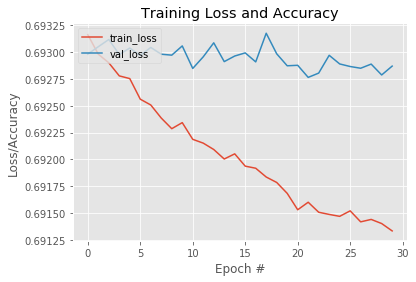

In [77]:
import matplotlib.pyplot as plt
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = len(history.history['loss'])
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
#plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [44]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)

In [45]:
images_per_row = 16

In [69]:
history.model.layers[0].weights[0].shape

TensorShape([Dimension(30), Dimension(13), Dimension(2056)])